In [1]:
import os
import cv2
import random

from glob import glob
from evaluate import load
from natsort import natsorted
from pathlib import Path

from BDRC.inference import OCRInference
from BDRC.label_encoder import WylieEncoder
from BDRC.utils import create_dir, get_filename, read_ocr_model_config, show_image

/Users/eric/Desktop/Projects/Python/ocr-inference/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Vanilla Easter2
woodblock_config_file = "Models/BDRC/Woodblock/model_config.json"
woodblock_model_config = read_ocr_model_config(woodblock_config_file)
wooblock_label_encoder = WylieEncoder(woodblock_model_config.charset)
woodblock_inference = OCRInference(woodblock_model_config)


# Easter2b (fixed convolutions)
woodblock2b_config_file = "Models/BDRC/Woodblock-Easter2b/2026_1_12_6_10/model_config.json"
woodblock2b_model_config = read_ocr_model_config(woodblock2b_config_file)
wooblock2_label_encoder = WylieEncoder(woodblock2b_model_config.charset)
woodblock2_inference = OCRInference(woodblock2b_model_config)


# Easter2-Attention
woodblock2_att_config_file = "Models/BDRC/Woodblock-Easter2Attention/2026_1_11_9_32/model_config.json"
woodblock_att_model_config = read_ocr_model_config(woodblock2_att_config_file)
wooblock_att_label_encoder = WylieEncoder(woodblock_att_model_config.charset)
woodblock_att_inference = OCRInference(woodblock_att_model_config)


# Easter2-Vit
woodblock_vit_config_file = "Models/BDRC/Woodblock-Vit/2025_12_18_22_52/config.json"
woodblock_vit_model_config = read_ocr_model_config(woodblock_vit_config_file)
wooblock_vit_label_encoder = WylieEncoder(woodblock_vit_model_config.charset)
woodblock_vit_inference = OCRInference(woodblock_vit_model_config)

#ocr_model_config_file = "Models/BDRC/BigUCHAN_v1/config.json"


# cer scorer
cer_scorer = load("cer")

Available ONNX providers: ['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
Available ONNX providers: ['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
Available ONNX providers: ['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
Available ONNX providers: ['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']


In [3]:
# read test distributions
data_root = Path("Datasets/datasets--BDRC--Uchan-OCR-EVAL/snapshots/ce992d6ceb88284b8a394b3bec1285bf6da48960")
test_dist = {}

for sub_dir in data_root.iterdir():

    if os.path.isdir(sub_dir):
        distr = sub_dir.name
        lines = natsorted(glob(f"{str(sub_dir)}/*.jpg"))
        labels = natsorted(glob(f"{str(sub_dir)}/*.txt"))

        test_dist[sub_dir.name] = {"images" : lines, "labels" : labels}

        print(f"{distr} => Images: {len(lines)}, Labels: {len(labels)}")

21320269 => Images: 6, Labels: 6
I1KG4010343 => Images: 7, Labels: 7
15520027 => Images: 5, Labels: 5
20880034 => Images: 6, Labels: 6
16290115 => Images: 6, Labels: 6
I0TTBBC0080_0010135 => Images: 7, Labels: 7
17410210 => Images: 6, Labels: 6
I0TTBBC0040_0010039 => Images: 6, Labels: 6
20430451 => Images: 6, Labels: 6
I1KG5910016 => Images: 6, Labels: 6
15520015 => Images: 4, Labels: 4
15740086 => Images: 6, Labels: 6


Images: 7, Labels: 7
GT-Label: de//bla§ma'i§'byin§brlabs§'ba'§zhig§yin//dad§ldan§bla§ma§la§gus§de'i//nang§nas§rtogs§pa'i§ye§shes§de//rtag§dpyad§mkhan§la§ci§cha§yod//ces§dang/rje§btsun§gling§ras§kyis/cho
Prediction: gi/bla§mi§'byin§brlabs§'ba'§zhig§yin//nang§ldan§bla§ma§la§gus§de'i//nang§nas§rtogs§pa'i§ye§shes§de//brtag§dbubg§mkhan§la§ci§cha§yod//ces§dang§/rje§btsun§gring§ras§kyis/tshe/§
Cer Score: 0.11695906432748537


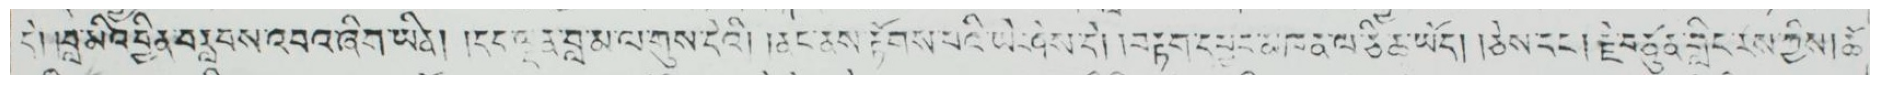

In [4]:
# single sample
test_set = "Datasets/datasets--BDRC--Uchan-OCR-EVAL/snapshots/ce992d6ceb88284b8a394b3bec1285bf6da48960/I0TTBBC0080_0010135"

lines = natsorted(glob(f"{str(test_set)}/*.jpg"))
labels = natsorted(glob(f"{str(test_set)}/*.txt"))
print(f"Images: {len(lines)}, Labels: {len(labels)}")

assert (len(lines) == len(labels))

sample_idx = random.randint(0, len(lines)-1)
image_path = lines[sample_idx]
label_path = labels[sample_idx]

label = wooblock_vit_label_encoder.read_label(label_path)

img = cv2.imread(image_path)
ocr_result = woodblock_vit_inference.run(img)
cer_score = cer_scorer.compute(predictions=[ocr_result], references=[label])

show_image(img)
print(f"GT-Label: {label}")
print(f"Prediction: {ocr_result}")
print(f"Cer Score: {cer_score}")

#### Evaluator class

In [5]:
from BDRC.inference import OCREvaluator

In [6]:
cer_scorer = load("cer")
evaluator = OCREvaluator(woodblock_vit_config_file, cer_scorer)

Available ONNX providers: ['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']


In [7]:
data_root = Path("Datasets/datasets--BDRC--Uchan-OCR-EVAL/snapshots/ce992d6ceb88284b8a394b3bec1285bf6da48960")
evaluation_sets = list()

for sub_dir in data_root.iterdir():

    if os.path.isdir(sub_dir):
        distr = sub_dir.name
        lines = natsorted(glob(f"{str(sub_dir)}/*.jpg"))
        labels = natsorted(glob(f"{str(sub_dir)}/*.txt"))
        print(f"{distr} => Images: {len(lines)}, Labels: {len(labels)}")
        
        result = evaluator.evaluate_distribution(distr, lines, labels)
        evaluation_sets.append(result)

21320269 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  8.84it/s]


I1KG4010343 => Images: 7, Labels: 7


100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


15520027 => Images: 5, Labels: 5


100%|██████████| 5/5 [00:00<00:00,  9.72it/s]


20880034 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00, 10.00it/s]


16290115 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


I0TTBBC0080_0010135 => Images: 7, Labels: 7


100%|██████████| 7/7 [00:00<00:00,  8.28it/s]


17410210 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  8.93it/s]


I0TTBBC0040_0010039 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


20430451 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  8.15it/s]


I1KG5910016 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  9.93it/s]


15520015 => Images: 4, Labels: 4


100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


15740086 => Images: 6, Labels: 6


100%|██████████| 6/6 [00:00<00:00,  8.65it/s]


In [11]:
# check sample score
evaluation_sets[2].cer_scores

{'15520027_line_0000': 0.037037037037037035,
 '15520027_line_0001': 0.2604166666666667,
 '15520027_line_0002': 0.168141592920354,
 '15520027_line_0003': 0.26436781609195403,
 '15520027_line_0004': 0.1134020618556701}